/var/folders/hb/s2xngzdj2bx11ztszsy_sg0r0000gn/T/ipykernel_9741/3623796493.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ecg = pd.Series(ecg).interpolate().fillna(method="bfill").fillna(method="ffill").values


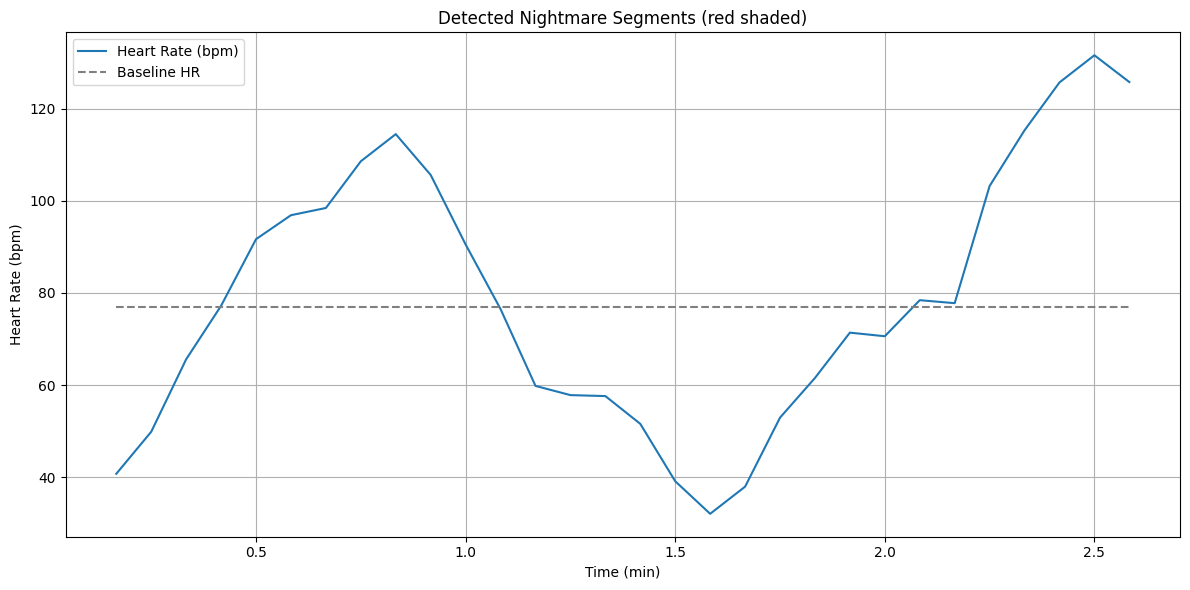

Detected 0 possible nightmare segments:


In [24]:
# ------------------------------------------------------------
# Nightmare Detection from ECG (Improved Rule-Based Version)
# ------------------------------------------------------------
# Requires: pip install neurokit2 pyedflib matplotlib pandas numpy scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sleepecg import compare_heartbeats, detect_heartbeats, read_mitdb
import neurokit2 as nk

# ---------------- USER CONFIG ----------------
# File path (choose one)
csv_path = "finalTestData.csv"       # your CSV file
edf_path = None                   # or "ecg_signal.edf"

# Sampling frequency (Hz)
fs = 250       # <-- change to 100 if needed

# Enable accelerometer artifact rejection if data present
use_acc = True

# ------------------------------------------------------------

# --------- LOAD DATA ----------
acc_data = None
if csv_path and csv_path.endswith(".csv"):
    df = pd.read_csv(csv_path)
    ecg = df.iloc[:, 0].values
elif edf_path and edf_path.endswith(".edf"):
    import pyedflib
    f = pyedflib.EdfReader(edf_path)
    n_signals = f.signals_in_file
    labels = f.getSignalLabels()
    ecg = f.readSignal(0)
    if use_acc:
        acc_cols = [i for i, l in enumerate(labels) if "Acc" in l or "ACC" in l]
        if acc_cols:
            acc_data = np.vstack([f.readSignal(i) for i in acc_cols]).T
    f._close()
    del f
else:
    raise ValueError("Please specify a valid csv_path or edf_path")

# Basic cleanup
ecg = pd.Series(ecg).interpolate().fillna(method="bfill").fillna(method="ffill").values
ecg = ecg - np.mean(ecg)

# --------- NOISE FILTERING (neurokit clean) ----------
ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method="neurokit")

# --------- R-PEAK DETECTION ----------
rpeaks, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
rpeaks = np.where(rpeaks["ECG_R_Peaks"] == 1)[0]
r_times = rpeaks / fs

# --------- COMPUTE HR AND RMSSD IN SLIDING WINDOWS ----------
def rmssd(rr):
    diff = np.diff(rr)
    return np.sqrt(np.mean(diff**2)) * 1000  # ms

window_sec = 20
step_sec   = 5
window_samples = int(window_sec * fs)
step_samples = int(step_sec * fs)

times = []
hr_list = []
rmssd_list = []

for start in np.arange(0, len(ecg_clean) - window_samples, step_samples):
    seg_start = start / fs
    seg_end = (start + window_samples) / fs
    mask = (r_times >= seg_start) & (r_times < seg_end)
    rr_seg = np.diff(r_times[mask])
    if len(rr_seg) > 2:
        hr_list.append(60 / np.mean(rr_seg))
        rmssd_list.append(rmssd(rr_seg))
    else:
        hr_list.append(np.nan)
        rmssd_list.append(np.nan)
    times.append(seg_start + window_sec / 2)

hr_arr = np.array(hr_list)
rmssd_arr = np.array(rmssd_list)
times = np.array(times)

# --------- OPTIONAL ACCELEROMETER ARTIFACT REJECTION ----------
if acc_data is not None:
    # Resample accelerometer to match HR window timeline
    acc_mag = np.linalg.norm(acc_data, axis=1)
    acc_mag = acc_mag - np.mean(acc_mag)
    # Downsample
    factor = int(len(acc_mag) / len(times))
    acc_resampled = np.abs(acc_mag[::factor])
    acc_std = pd.Series(acc_resampled).rolling(3, center=True, min_periods=1).std()
    motion_mask = acc_std > np.percentile(acc_std, 80)
else:
    motion_mask = np.zeros_like(hr_arr, dtype=bool)

# --------- BASELINE COMPUTATION (10 min rolling) ----------
baseline_win = int((600 / step_sec))  # 10 min baseline
hr_baseline = pd.Series(hr_arr).rolling(baseline_win, min_periods=1, center=True).median()
rmssd_baseline = pd.Series(rmssd_arr).rolling(baseline_win, min_periods=1, center=True).median()

# --------- RULE-BASED DETECTION ----------
# stricter thresholds for better specificity
hr_thresh = (hr_arr > hr_baseline * 1.25) | (hr_arr - hr_baseline >= 12)
hrv_thresh = rmssd_arr < rmssd_baseline * 0.7
nightmare_mask = hr_thresh & hrv_thresh & (~motion_mask) & (times > 20*60)

# Merge close events (<30 s apart)
nightmare_events = []
if np.any(nightmare_mask):
    idx = np.where(nightmare_mask)[0]
    group = [idx[0]]
    for i in range(1, len(idx)):
        if (idx[i] - idx[i - 1]) * step_sec <= 30:
            group.append(idx[i])
        else:
            nightmare_events.append((times[group[0]], times[group[-1]]))
            group = [idx[i]]
    nightmare_events.append((times[group[0]], times[group[-1]]))

# --------- PLOT RESULTS ----------
plt.figure(figsize=(12,6))
plt.plot(times/60, hr_arr, label="Heart Rate (bpm)", color="C0")
plt.plot(times/60, hr_baseline, "--", color="gray", label="Baseline HR")

for (start_t, end_t) in nightmare_events:
    plt.axvspan(start_t/60, end_t/60, color="red", alpha=0.3)

plt.xlabel("Time (min)")
plt.ylabel("Heart Rate (bpm)")
plt.title("Detected Nightmare Segments (red shaded)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Detected {len(nightmare_events)} possible nightmare segments:")
for i,(s,e) in enumerate(nightmare_events):
    print(f"  Event {i+1}: {s:.1f}–{e:.1f} s  ({(e-s):.1f} s long)")


In [18]:

testdf = pd.read_csv("largeECG.csv")
testdf.head()

,ECG
0,0.000669
1,0.000503
2,0.000483
3,0.000601
4,0.000552


In [25]:


# download and read data
record = list(pd.read_csv("finalTestData.csv"))

# detect heartbeats
detection = detect_heartbeats(record.ecg, record.fs)

# evaluation and visualization
TP, FP, FN = compare_heartbeats(detection, record.annotation, int(record.fs / 10))

t = np.arange(len(record.ecg)) / record.fs

fig, ax = plt.subplots(3, sharex=True, figsize=(10, 8))

ax[0].plot(t, record.ecg, color="k", zorder=1, label="ECG")
ax[0].scatter(
    record.annotation / record.fs,
    record.ecg[record.annotation],
    marker="o",
    color="g",
    s=50,
    zorder=2,
    label="annotation",
)
ax[0].set_ylabel("raw signal in mV")

ax[1].eventplot(
    detection / record.fs,
    linelength=0.5,
    linewidth=0.5,
    color="k",
    zorder=1,
    label="detection",
)
ax[1].scatter(
    FN / record.fs,
    np.ones_like(FN),
    marker="x",
    color="r",
    s=70,
    zorder=2,
    label="FN",
)
ax[1].scatter(
    FP / record.fs,
    np.ones_like(FP),
    marker="+",
    color="orange",
    s=70,
    zorder=2,
    label="FP",
)
ax[1].set_yticks([])
ax[1].set_ylabel("heartbeat events")

ax[2].plot(
    detection[1:] / record.fs,
    60 / (np.diff(detection) / record.fs),
    label="heartrate in bpm",
)
ax[2].set_ylabel("beats per minute")
ax[2].set_xlabel("time in seconds")

for ax_ in ax.flat:
    ax_.legend(loc="upper right")
    ax_.grid(axis="x")

fig.suptitle(
    f"Record ID: {record.id}, lead: {record.lead}\n"
    + f"Recall: {len(TP) / (len(TP) + len(FN)):.2%}, "
    + f"Precision: {len(TP) / (len(TP) + len(FP)):.2%}",
)

plt.show()

AttributeError: 'list' object has no attribute 'ecg'

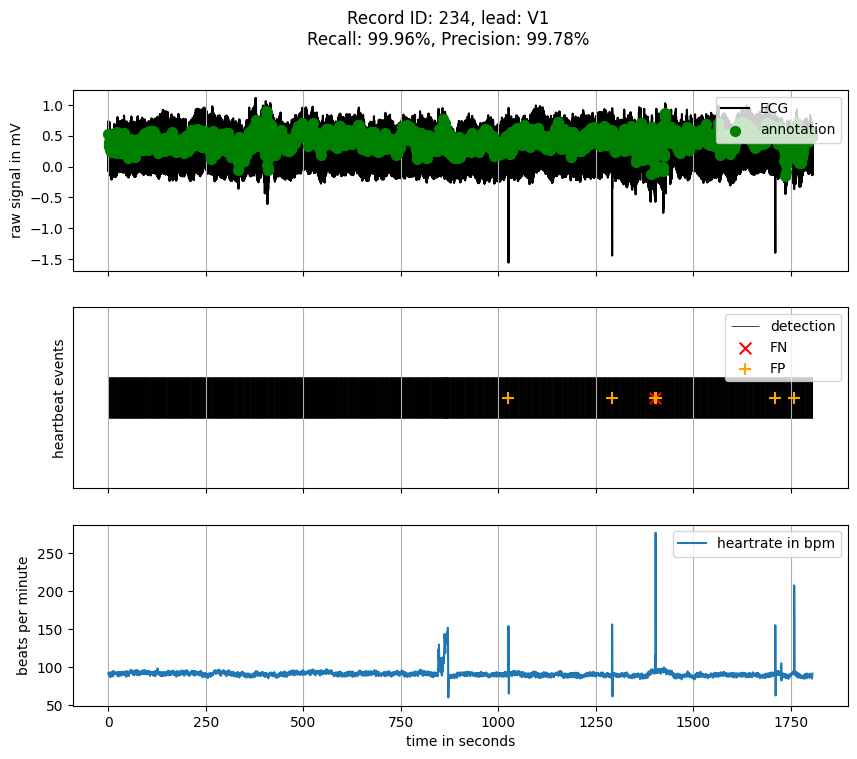

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from sleepecg import compare_heartbeats, detect_heartbeats, read_mitdb

# download and read data
record = list(read_mitdb(records_pattern="234"))[1]

# detect heartbeats
detection = detect_heartbeats(record.ecg, record.fs)

# evaluation and visualization
TP, FP, FN = compare_heartbeats(detection, record.annotation, int(record.fs / 10))

t = np.arange(len(record.ecg)) / record.fs

fig, ax = plt.subplots(3, sharex=True, figsize=(10, 8))

ax[0].plot(t, record.ecg, color="k", zorder=1, label="ECG")
ax[0].scatter(
    record.annotation / record.fs,
    record.ecg[record.annotation],
    marker="o",
    color="g",
    s=50,
    zorder=2,
    label="annotation",
)
ax[0].set_ylabel("raw signal in mV")

ax[1].eventplot(
    detection / record.fs,
    linelength=0.5,
    linewidth=0.5,
    color="k",
    zorder=1,
    label="detection",
)
ax[1].scatter(
    FN / record.fs,
    np.ones_like(FN),
    marker="x",
    color="r",
    s=70,
    zorder=2,
    label="FN",
)
ax[1].scatter(
    FP / record.fs,
    np.ones_like(FP),
    marker="+",
    color="orange",
    s=70,
    zorder=2,
    label="FP",
)
ax[1].set_yticks([])
ax[1].set_ylabel("heartbeat events")

ax[2].plot(
    detection[1:] / record.fs,
    60 / (np.diff(detection) / record.fs),
    label="heartrate in bpm",
)
ax[2].set_ylabel("beats per minute")
ax[2].set_xlabel("time in seconds")

for ax_ in ax.flat:
    ax_.legend(loc="upper right")
    ax_.grid(axis="x")

fig.suptitle(
    f"Record ID: {record.id}, lead: {record.lead}\n"
    + f"Recall: {len(TP) / (len(TP) + len(FN)):.2%}, "
    + f"Precision: {len(TP) / (len(TP) + len(FP)):.2%}",
)

plt.show()

In [26]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import neurokit2 as nk
import pyedflib

# --- Parameters ---
file_path = "finalTestData.csv"   # or "your_ecg_file.edf"
fs = 250                           # sampling frequency (Hz). change to 100 if needed
wavelet_widths = np.arange(1, 10)  # scales for wavelet transform
baseline_minutes = 10              # rolling baseline window length
hr_thresh = 1.25                   # 25% HR increase threshold
rmssd_thresh = 0.7                 # 30% RMSSD drop threshold

# --- Load ECG ---
if file_path.endswith(".edf"):
    with pyedflib.EdfReader(file_path) as f:
        ecg = f.readSignal(0)
else:
    df = pd.read_csv(file_path)
    col = df.columns[0]
    ecg = df[col].values

# --- Preprocess ECG ---
ecg = ecg - np.mean(ecg)
ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method='neurokit')

# --- Wavelet-based R-peak detection ---
# Continuous Wavelet Transform (CWT) with Ricker (Mexican hat) wavelet
cwtmatr = sig.cwt(ecg_clean, sig.ricker, wavelet_widths)

# Combine scales (sum of absolute values)
cwt_sum = np.sum(np.abs(cwtmatr), axis=0)

# Find local maxima as potential R peaks
peaks, _ = sig.find_peaks(cwt_sum, distance=int(0.25 * fs), prominence=np.std(cwt_sum)*1.5)

# --- Compute HR and HRV metrics ---
rpeaks = np.array(peaks)
rr_intervals = np.diff(rpeaks) / fs
hr = 60.0 / rr_intervals
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

# Create time arrays
time = np.arange(len(ecg_clean)) / fs
rr_time = time[rpeaks[1:]]  # assign RR interval to right-side R-peak

# --- Rolling baseline HR & RMSSD ---
win = int((baseline_minutes * 60) / np.median(np.diff(rr_time)))
hr_baseline = pd.Series(hr).rolling(win, min_periods=1).median()
rmssd_series = pd.Series(
    [np.sqrt(np.mean(np.square(np.diff(rr_intervals[max(0, i-5):i+1]))))
     for i in range(len(rr_intervals))]
)
rmssd_baseline = rmssd_series.rolling(win, min_periods=1).median()

# --- Rule-based nightmare detection ---
hr_ratio = hr / hr_baseline
rmssd_ratio = rmssd_series / rmssd_baseline
nightmare_mask = (hr_ratio > hr_thresh) & (rmssd_ratio < rmssd_thresh)

# --- Plot Results ---
plt.figure(figsize=(14, 6))
plt.plot(rr_time/60, hr, color='blue', label='Heart Rate (BPM)', linewidth=1.5)
plt.plot(rr_time/60, hr_baseline, color='gray', linestyle='--', label='Baseline HR')

# Shade nightmare segments
for i in range(len(rr_time)-1):
    if nightmare_mask.iloc[i]:
        plt.axvspan(rr_time[i]/60, rr_time[i+1]/60, color='red', alpha=0.25)

plt.xlabel("Time (minutes)")
plt.ylabel("Heart Rate (BPM)")
plt.title("Nightmare Detection using Wavelet-based R-peak Detection")
plt.legend()
plt.grid(True)
plt.show()

# --- Summary ---
n_events = np.sum(nightmare_mask)
print(f"Detected {n_events} potential nightmare events.")


AttributeError: module 'scipy.signal' has no attribute 'cwt'

In [32]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import neurokit2 as nk
import pyedflib

# --- Parameters ---
file_path = "finalTestData.csv"   # or "your_ecg_file.edf"
fs = 250                           # Sampling frequency (Hz). Change to 100 if needed
baseline_minutes = 10              # Rolling baseline window length (minutes)
hr_thresh = 1.25                   # HR threshold ratio (e.g. 1.25 = +25%)
rmssd_thresh = 0.7                 # RMSSD threshold ratio (e.g. 0.7 = -30%)

# --- Load ECG ---
if file_path.endswith(".edf"):
    with pyedflib.EdfReader(file_path) as f:
        ecg = f.readSignal(0)
else:
    df = pd.read_csv(file_path)
    ecg = df[df.columns[0]].values


def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal

ecg_2hz = resample_by_interpolation(df['ECG'], settings['fs'], 2)

df_2hz = pd.DataFrame(ecg_2hz, columns=['ECG'])
df_2hz['Seconds'] = np.arange(0, len(df_2hz)) / 2


# --- Clean signal ---
ecg = ecg - np.mean(ecg)
ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method="neurokit")

# --- Wavelet-based QRS enhancement ---
# Create Ricker ("Mexican hat") wavelet
def ricker_wavelet(M, a):
    A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
    wsq = (np.arange(0, M) - (M - 1)/2)**2
    return A * (1 - wsq / a**2) * np.exp(-wsq / (2 * a**2))

width = int(0.1 * fs)  # roughly 100 ms width for QRS
wavelet = ricker_wavelet(6 * width + 1, width)
cwt_sum = np.convolve(ecg_clean, wavelet, mode="same")

# Find peaks in the transformed signal
distance = int(0.25 * fs)  # 0.25 s refractory period (~240 bpm)
prominence = np.std(cwt_sum) * 1.5
peaks, _ = sig.find_peaks(cwt_sum, distance=distance, prominence=prominence)

# --- Compute HR and HRV ---
rpeaks = np.array(peaks)
rr_intervals = np.diff(rpeaks) / fs
hr = 60.0 / rr_intervals
rr_time = rpeaks[1:] / fs  # time for each RR interval

# RMSSD per window
rmssd_series = pd.Series([
    np.sqrt(np.mean(np.square(np.diff(rr_intervals[max(0, i-5):i+1]))))
    for i in range(len(rr_intervals))
])

# --- Rolling baseline ---
win = int((baseline_minutes * 60) / np.median(np.diff(rr_time)))
hr_baseline = pd.Series(hr).rolling(win, min_periods=1).median()
rmssd_baseline = rmssd_series.rolling(win, min_periods=1).median()

# --- Rule-based detection ---
hr_ratio = hr / hr_baseline
rmssd_ratio = rmssd_series / rmssd_baseline
nightmare_mask = (hr_ratio > hr_thresh) & (rmssd_ratio < rmssd_thresh)

# --- Plot Results ---
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Heart rate plot
axes[0].plot(rr_time/60, hr, color="blue", label="Heart Rate (BPM)", linewidth=1.5)
axes[0].plot(rr_time/60, hr_baseline, color="gray", linestyle="--", label="Baseline HR")
for i in range(len(rr_time)-1):
    if nightmare_mask.iloc[i]:
        axes[0].axvspan(rr_time[i]/60, rr_time[i+1]/60, color="red", alpha=0.25)
axes[0].set_ylabel("HR (BPM)")
axes[0].legend()
axes[0].grid(True)

# RMSSD plot
axes[1].plot(rr_time/60, rmssd_series, color="green", label="RMSSD")
axes[1].plot(rr_time/60, rmssd_baseline, color="gray", linestyle="--", label="Baseline RMSSD")
for i in range(len(rr_time)-1):
    if nightmare_mask.iloc[i]:
        axes[1].axvspan(rr_time[i]/60, rr_time[i+1]/60, color="red", alpha=0.25)
axes[1].set_xlabel("Time (minutes)")
axes[1].set_ylabel("RMSSD (s)")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Nightmare Detection using Wavelet-based R-Peak Detection", fontsize=14)
plt.show()

# --- Summary ---
print(f"Detected {np.sum(nightmare_mask)} potential nightmare events.")


KeyError: 'ECG'

Detected 370 R-peaks.


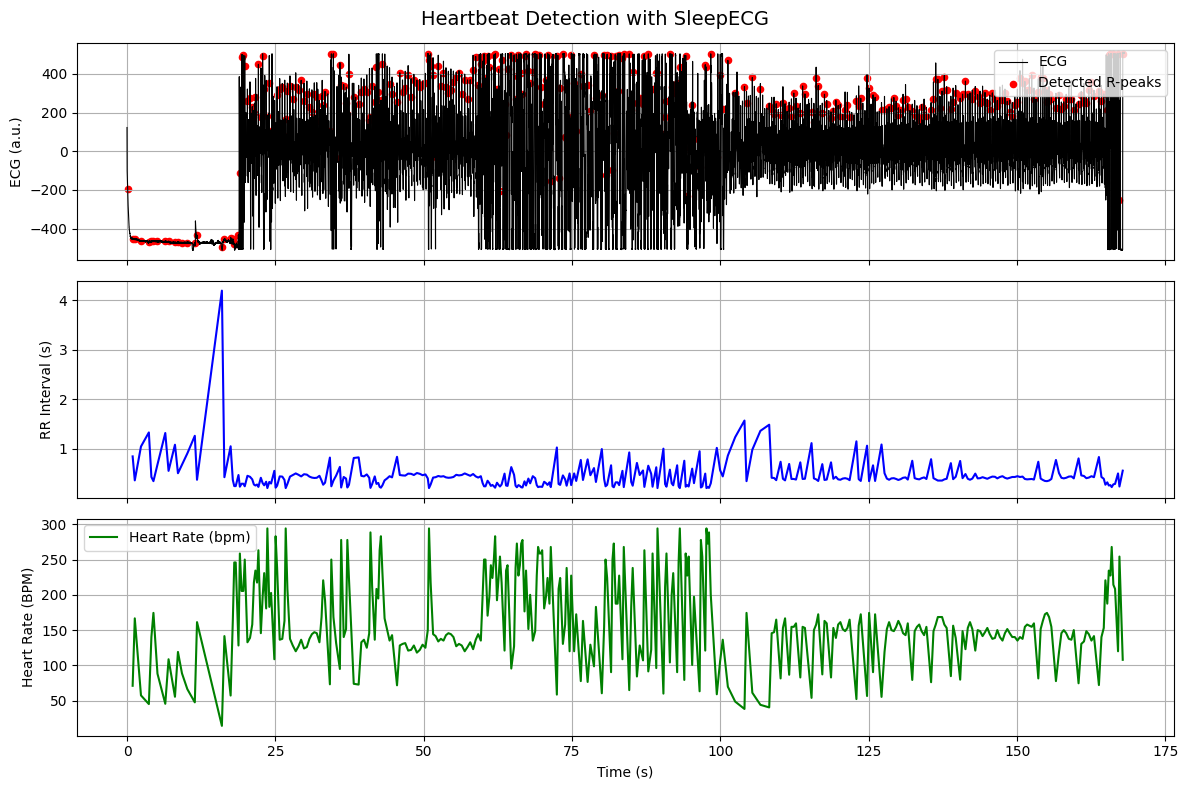

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sleepecg import detect_heartbeats
import pyedflib

# === USER PARAMETERS ===
file_path = "finalTestData.csv"   # or "your_ecg_file.edf"
fs = 250                          # Sampling frequency (Hz) — change to 100 if needed

# === LOAD ECG DATA ===
if file_path.endswith(".edf"):
    with pyedflib.EdfReader(file_path) as f:
        ecg = f.readSignal(0)
else:
    df = pd.read_csv(file_path)
    ecg = df[df.columns[0]].to_numpy()

ecg = ecg.astype(float)
t = np.arange(len(ecg)) / fs  # time vector (s)

# === DETECT HEARTBEATS ===
rpeaks = detect_heartbeats(ecg, fs)

print(f"Detected {len(rpeaks)} R-peaks.")

# === COMPUTE HEART RATE (BPM) ===
rr_intervals = np.diff(rpeaks) / fs
hr = 60 / rr_intervals
hr_time = rpeaks[1:] / fs

# === PLOTTING ===
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(12, 8))

# Raw ECG with detected peaks
ax[0].plot(t, ecg, color="black", lw=0.8, label="ECG")
ax[0].scatter(rpeaks / fs, ecg[rpeaks], color="red", s=20, label="Detected R-peaks")
ax[0].set_ylabel("ECG (a.u.)")
ax[0].legend(loc="upper right")
ax[0].grid(True)

# RR intervals
ax[1].plot(rpeaks[1:] / fs, rr_intervals, color="blue")
ax[1].set_ylabel("RR Interval (s)")
ax[1].grid(True)

# Heart rate
ax[2].plot(hr_time, hr, color="green", label="Heart Rate (bpm)")
ax[2].set_ylabel("Heart Rate (BPM)")
ax[2].set_xlabel("Time (s)")
ax[2].legend()
ax[2].grid(True)

plt.suptitle("Heartbeat Detection with SleepECG", fontsize=14)
plt.tight_layout()
plt.show()
